Running a simulation with SHyFT
=========

### This notebook is guiding through the simulation process of a catchment. The following steps are described in detail:
1. **Configuration of a SHyFT simulation run**
2. **Running a SHyFT simulation**
3. **Post-processing:** Fetching simulation results from the simulator-object.

<i>© Felix Matt, University of Oslo</i>

## 1. Configuration of a SHyFT simulation

* We use the **Simulator**-object in orchestration2/shyft_runner.py to conduct a calibration
* The settings of a simulation are set in the configuration files:
    
    * **configuration.yaml**:  
        * basic **configuration for the model run**
        * pointing to the other configuration-files
        * setting the time frame of the simulation (start date, step, nr of steps)
        * setting output variables and files
    
    * **model.yaml**
        * selection of the **model stack** (stack of sub-routines); in this example the PTGSK-stack:
            * **Priestley Taylor** for evapotranspiration
            * **GammaSnow** for handling of seasonal snow
            * **Kirchner-equation** for simulated discharge
        * setting the **model parameters**
    
    * **region.yaml**
        * points to **cell-data** database
    
    * **datasets.yaml**
        * points to **input time-series** database  
          each station must be specified (database as pure **data-container**)
        

In [1]:
# python modules we use
%pylab inline
import os
import sys
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# setting up the environment
shyft_path = os.path.abspath(os.path.realpath('../shyft-FA'))  # update this for your case!
sys.path.append(shyft_path)

In [3]:
from shyft import api
from shyft.api.pt_gs_k import PTGSKModel
from shyft.orchestration.simulator import SimpleSimulator
from shyft.repository import (
    netcdf, geo_ts_repository_collection, interpolation_parameter_repository,
    default_state_repository)
from shyft.repository.netcdf import yaml_config

In [4]:
# create a time axis
year, month, day, hour = 2005, 7, 1, 0
start_time = api.Calendar().time(api.YMDhms(year, month, day, hour))
run_timestep, number_of_steps = api.deltahours(24), 2557   # 1 day step during 7 years
time_axis = api.Timeaxis(start_time, run_timestep, number_of_steps)

In [5]:
# set up configuration
catch_dir = "./atnsjoen_catchment/"
region_config = yaml_config.RegionConfig(catch_dir + "region.yaml")
model_config = yaml_config.ModelConfig(catch_dir + "model_calibrated.yaml")
dataset_config = yaml_config.YamlContent(catch_dir + "datasets.yaml")
model_t = PTGSKModel  # model
epsg = "32633"        # simulation coordinate system
region_model = netcdf.RegionModelRepository(region_config, model_config, model_t, epsg)
interp_repos = interpolation_parameter_repository.InterpolationParameterRepository(model_config)

# Create a repository of geo-located timeseries for stations
netcdf_geo_ts_repos = []
for source in dataset_config.sources:
    station_file = source["params"]["stations_met"]
    netcdf_geo_ts_repos.append(netcdf.GeoTsRepository(source["params"], station_file, ""))
geo_ts = geo_ts_repository_collection.GeoTsRepositoryCollection(netcdf_geo_ts_repos)

In [6]:
# fake id's
region_id = 0
interpolation_id=0
# set up the simulator
simulator = SimpleSimulator(region_id, interpolation_id, region_model, geo_ts, interp_repos, None)

## 2. Running a SHyFT simulation

In [7]:
# create an initial state
n_cells = simulator.region_model.size()
state_repos = default_state_repository.DefaultStateRepository(model_t, n_cells)
state = state_repos.get_state(0)

In [8]:
# RUN THE MODEL!
simulator.run(time_axis, state)

2 temperature series found.
1 wind_speed series found.
2 precipitation series found.
1 relative_humidity series found.
4 radiation series found.


#### EXERCISE 1:
Only one radiation station is found.
* Find out how many radiation time series the database provides.
You can use the [previous notebook](00_reading_shyft_database.ipynb) to do so.
* Change the dataset-configuration, so that the simulations takes the additional radiation-series into account.

## 3. Post processing

### a) Fetching simulated discharge from the simulator-object

In [9]:
# get simulated time series of discharge
cid = 1
found_discharge = simulator.region_model.statistics.discharge([cid])
sim = np.array([found_discharge.value(i) for i in range(found_discharge.size())])
sim_time = np.array([found_discharge.time(i) for i in range(found_discharge.size())])
sim_date = [datetime.datetime.utcfromtimestamp(t) for t in sim_time]

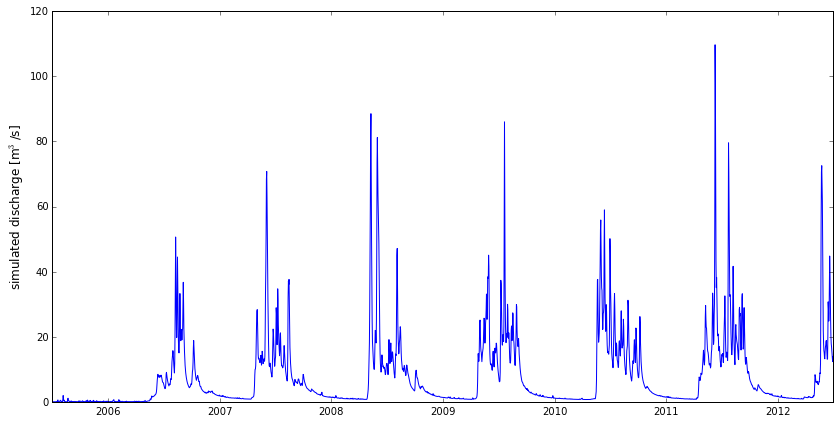

In [10]:
plt.figure(figsize(14,7))
plt.plot(sim_date,sim)
plt.ylabel("simulated discharge [m$^3$/s]", fontsize=12)

### b) Fetching cell data from the simulator-object

In [11]:
# Fetching a list of cells
cells = simulator.region_model.statistics.cells

# getting the time axes of the simulation and generating a list of datetime-objects from it
ta = simulator.region_model.time_axis
start_date = datetime.datetime.utcfromtimestamp(ta.start())
dates = [start_date + datetime.timedelta(seconds=n*ta.delta()) for n in range(ta.size())]

# Collecting the time series of a response variable (e.g. the snow-covered-area (sca))
# for each of the cells
sca_cells = []
sca_dates = []
start_idx = dates.index(datetime.datetime(2008, 10, 1))
for t in range(start_idx, start_idx + 365):  # one year of data
    sca_dates.append(dates[t])
    sca_cells.append([cell.rc.snow_sca.v[t] for cell in cells])
    
# fetching x- and y-location of the cells
x = [cell.geo.mid_point().x for cell in cells]
y = [cell.geo.mid_point().y for cell in cells]

/home/faltet/miniconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


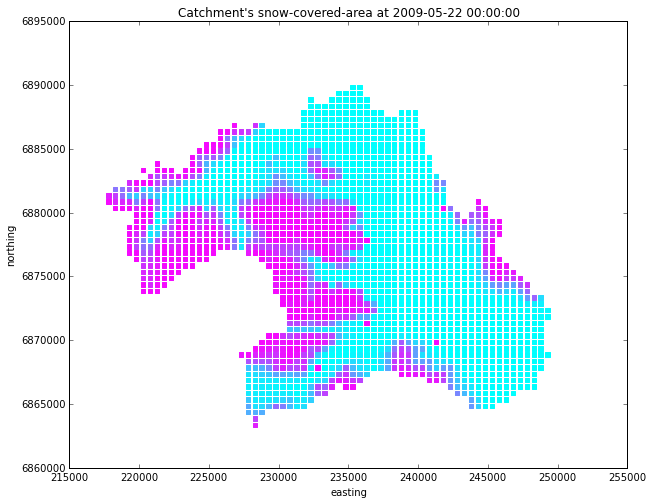

In [12]:
day_of_hyd_year = 233

plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('cool')
plt.scatter(x,y, color=cm(sca_cells[day_of_hyd_year]), marker = 's')
plt.xlabel("easting")
plt.ylabel("northing")
plt.title("Catchment's snow-covered-area at {}".format(sca_dates[day_of_hyd_year]))